# 3D CNN over 11x11 single-station-sub-rasters, leaving out the worst stations
** Features: Precipitation, Mean-Air-Temperature **

Ausgabe: Veränderung Messstand 4 Wochen nach letztem Messstand zu letztem Messstand

Eingabe:
- 11x11 (ca. 11kx11km) Raster wöchentlich summierter Niederschlag für 8 Wochen vor letztem Messstand und vorhergesagter für die 4 Wochen nach letztem Messstand
- 11x11 monatl. Durchschnittstemperatur für die 3 vorkommenden Monate
- letzter Messstand und Messstand 4 Wochen davor, jeweils als Veränderung zu 4 Wochen davor

In [1]:
import numpy as np
import pandas as pd
import rasterio as rio
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import glob 
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn import preprocessing
import datetime


%load_ext tensorboard

In [2]:
data_drive = r'F:/'

## 1. load Data

In [3]:
stammdaten = pd.read_excel(data_drive +r'GruV-Net/data/Stammdaten_HE.xlsx')
stammdaten.set_index('Proj_ID', inplace=True)
gw_weekly = pd.read_csv(data_drive +r'GruV-Net/data/groundwater_levels_preprocessed_hesse/weekly/gw_lvl_complete.csv')
gw_weekly.set_index('Datum', inplace=True)

In [4]:
rws_folder = data_drive + r'GruV-Net/data/precipitation/weekly-sum/GTiff/'

rws_files = glob.glob(rws_folder+'*2008*.tif') + glob.glob(rws_folder+'*2009*.tif') + glob.glob(rws_folder+'*2010*.tif') + glob.glob(rws_folder+'*2011*.tif') + glob.glob(rws_folder+'*2012*.tif') +glob.glob(rws_folder+'*2013*.tif') + glob.glob(rws_folder+'*2014*.tif') + glob.glob(rws_folder+'*2015*.tif') + glob.glob(rws_folder+'*2016*.tif') + glob.glob(rws_folder+'*2017*.tif')
rws_files.sort()
temp_folder = data_drive + r'GruV-Net/data/temperature/GTiff/'

In [5]:
def assemble_instances(regnie_files, temp_path):
    x_regnie = []
    x_temp = []
    x_gw = []
    y = []
    instances_list = []

    worst_stations = ['HE_15725', 'HE_5099', 'HE_10319']

    regnie_file_names = list(map(os.path.basename, regnie_files))

    for i in range(0, len(regnie_files)-11):
        regnie_srcs =  []
        for l in range(0,12):
            #print(regnie_files[i+l])
            regnie_srcs.append(rio.open(regnie_files[i+l]))
        temp_srcs = []
        for l in (2, 6, 10):
            #Monatsauswahl noch tricky
            #print(temp_path+'TAMM_'+ regnie_file_names[i+l][9:11]+'_'+regnie_file_names[i+l][4:8]+'_01.tif')
            temp_srcs.append(rio.open(temp_path+'TAMM_'+ regnie_file_names[i+l][9:11]+'_'+regnie_file_names[i+l][4:8]+'_01.tif'))

        stations = gw_weekly.loc[regnie_file_names[i][4:14], : ].dropna().index.tolist()
        for s in stations:
            if s in worst_stations: continue

            instance_desc = []
            instance_desc.append(s)
            east = stammdaten.loc[s]['OSTWERT']
            north = stammdaten.loc[s]['NORDWERT']
            row, col = regnie_srcs[0].index(east, north)

            instance_regnie = np.ndarray(shape=(12))
            # das ist noch ein Problem, manche Stationen zu nah am Rand
            try:
                for j in range(12):
                    r = regnie_srcs[j].read(1, window=rio.windows.Window(col-5, row-5, 11, 11))
                    instance_regnie[j] = r.mean()
                    instance_desc.append(regnie_srcs[j].name[48:-4])
            except ValueError:
                continue

            instance_temp = np.ndarray(shape=(3))
            try:
                for j in range(3):
                    r = temp_srcs[j].read(1, window=rio.windows.Window(col-5, row-5, 11, 11))
                    instance_temp[j] = r.mean()
                    instance_desc.append(temp_srcs[j].name[35:-4])
            except ValueError:
                continue

            instance_gw = []
            try:    
                for k in [0, 4, 8]:
                    #lieber in Prozent?
                    change =  gw_weekly.loc[regnie_file_names[i+k+4][4:14], : ][s] - gw_weekly.loc[regnie_file_names[i+k][4:14], : ][s]
                    if np.isnan(change):
                        raise Exception()
                    else: 
                        instance_gw = np.append(instance_gw, change)
                        instance_desc.append(regnie_file_names[i+k+4][4:14])
                        instance_desc.append(change)
            except Exception:
                continue 

            x_regnie.append(instance_regnie)
            x_temp.append(instance_temp)
            x_gw.append(instance_gw[:2])
            instances_list.append(instance_desc)
            y = y + list(instance_gw[2:])
    return np.array(x_regnie), np.array(x_temp), np.array(x_gw), np.array(y), instances_list

In [6]:
X_regnie, X_temp, X_gw, y, instances_list = assemble_instances(rws_files, temp_folder)

In [7]:
#pd.DataFrame(instances_list)

In [7]:
print(X_regnie.shape)
print(X_temp.shape)
print(X_gw.shape)
print(y.shape)

(229478, 12)
(229478, 3)
(229478, 2)
(229478,)


In [8]:
 np.save(data_drive +r'GruV-Net/data/assembled_instances/cnn/X_regnie_2008-2017_wo-worst_raster-mean.npy', X_regnie)
np.save(data_drive +r'GruV-Net/data/assembled_instances/cnn/X_temp_2008-2017_wo-worst_raster-mean.npy', X_temp)
np.save(data_drive +r'GruV-Net/data/assembled_instances/cnn/X_gw_2008-2017_wo-worst_raster-mean.npy', X_gw)
np.save(data_drive +r'GruV-Net/data/assembled_instances/cnn/Y_2008-2017_wo-worst_raster-mean.npy', y)

## 2. Define and train CNN

In [3]:
X_regnie = np.load(data_drive +r'GruV-Net/data/assembled_instances/cnn/X_regnie_2008-2017_wo-worst_raster-mean.npy')
X_temp = np.load(data_drive +r'GruV-Net/data/assembled_instances/cnn/X_temp_2008-2017_wo-worst_raster-mean.npy')
X_gw = np.load(data_drive +r'GruV-Net/data/assembled_instances/cnn/X_gw_2008-2017_wo-worst_raster-mean.npy')
y = np.load(data_drive +r'GruV-Net/data/assembled_instances/cnn/y_2008-2017_wo-worst_raster-mean.npy')

In [4]:
regnie_input = keras.Input(shape=(12), name="regnie")
temp_input = keras.Input(shape=(3), name="temp")
gw_input = keras.Input(shape=(2), name="gw")

x = layers.concatenate([regnie_input, temp_input, gw_input])
x = layers.Dense(64)(x)
x = layers.Dense(32)(x)
pred = layers.Dense(1)(x)

GruV = keras.Model(
    inputs=[regnie_input, temp_input, gw_input],
    outputs=[pred],
)

In [5]:
GruV.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error',tf.keras.metrics.RootMeanSquaredError()])
GruV.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
regnie (InputLayer)             [(None, 12)]         0                                            
__________________________________________________________________________________________________
temp (InputLayer)               [(None, 3)]          0                                            
__________________________________________________________________________________________________
gw (InputLayer)                 [(None, 2)]          0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 17)           0           regnie[0][0]                     
                                                                 temp[0][0]                   

In [6]:
hist = []
cv_round = 1

for train_idx, test_idx in TimeSeriesSplit(5).split(X_regnie):
    X_regnie_train, X_regnie_test = X_regnie[train_idx], X_regnie[test_idx]
    X_temp_train, X_temp_test = X_temp[train_idx], X_temp[test_idx]
    X_gw_train, X_gw_test = X_gw[train_idx], X_gw[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    regnie_scaler = preprocessing.StandardScaler().fit(X_regnie_train)
    temp_scaler = preprocessing.StandardScaler().fit(X_temp_train)
    gw_scaler = preprocessing.MaxAbsScaler().fit(X_gw_train)

    X_regnie_train = regnie_scaler.transform(X_regnie_train)
    X_regnie_test = regnie_scaler.transform(X_regnie_test)
    X_temp_train = temp_scaler.transform(X_temp_train)
    X_temp_test = temp_scaler.transform(X_temp_test)
    X_gw_train = gw_scaler.transform(X_gw_train)
    X_gw_test = gw_scaler.transform(X_gw_test)

    log_dir="logs\\fit\\raster-mean-" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "-"+str(cv_round)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    h = GruV.fit(
    {"regnie": X_regnie_train, "temp": X_temp_train, "gw": X_gw_train},
    y_train,
    epochs=20,
    validation_data=({"regnie": X_regnie_test, "temp": X_temp_test, "gw": X_gw_test}, y_test),
    callbacks=[tensorboard_callback]
    )

    hist.append(h)
    cv_round += 1

 0.2943 - val_root_mean_squared_error: 0.5768
Train on 76494 samples, validate on 38246 samples
Epoch 1/20
76494/76494 [==============================] - 11s 141us/sample - loss: 0.3056 - mean_absolute_error: 0.2646 - root_mean_squared_error: 0.5528 - val_loss: 0.2974 - val_mean_absolute_error: 0.2583 - val_root_mean_squared_error: 0.5453
Epoch 2/20
76494/76494 [==============================] - 11s 140us/sample - loss: 0.3051 - mean_absolute_error: 0.2642 - root_mean_squared_error: 0.5523 - val_loss: 0.2974 - val_mean_absolute_error: 0.2621 - val_root_mean_squared_error: 0.5453
Epoch 3/20
76494/76494 [==============================] - 11s 141us/sample - loss: 0.3045 - mean_absolute_error: 0.2635 - root_mean_squared_error: 0.5518 - val_loss: 0.2992 - val_mean_absolute_error: 0.2636 - val_root_mean_squared_error: 0.5470
Epoch 4/20
76494/76494 [==============================] - 11s 140us/sample - loss: 0.3046 - mean_absolute_error: 0.2640 - root_mean_squared_error: 0.5519 - val_loss: 0.2

In [ ]:
for i in range(5):
    plt.plot(hist[i].history['val_root_mean_squared_error'])
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['Split 1', 'Split 2', 'Split 3', 'Split 4', 'Split 5'], loc='upper left')
plt.show()

In [3]:
%tensorboard --logdir logs/fit

ERROR: Failed to launch TensorBoard (exited with 0).
Contents of stderr:
failed to create process.

## 3. Analysis

In [31]:
instances_list_train, instances_list_test = train_test_split(instances_list, test_size=0.2, shuffle=False)

In [20]:
preds = GruV.predict({"regnie": X_regnie_test, "temp": X_temp_test, "gw": X_gw_test})

In [34]:
preds.flatten()

array([-0.01340353, -0.01682723, -0.04535124, ..., -0.0298704 ,
        0.03477551,  0.04969199], dtype=float32)

In [22]:
y_test

array([-0.205, -0.205, -0.01 , ...,  0.59 ,  0.05 ,  0.13 ])

In [23]:
ae = np.abs(preds.flatten() - y_test)

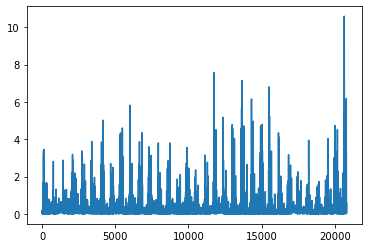

In [24]:
plt.plot(ae)

In [25]:
np.argmax(ae)

20651

In [26]:
worst_instances = (-ae).argsort()[:20]
worst_instances

array([20651, 11730, 13664, 15509, 20788, 14308,  6012, 20754, 13632,
       20649, 14310, 15540, 12359,  4172, 14425, 20789, 15038, 12990,
       13662, 20022], dtype=int64)

In [35]:
instances_list_test[20651]

['HE_6251',
 'rws_2017-09-18',
 'rws_2017-09-25',
 'rws_2017-10-02',
 'rws_2017-10-09',
 'rws_2017-10-16',
 'rws_2017-10-23',
 'rws_2017-10-30',
 'rws_2017-11-06',
 'rws_2017-11-13',
 'rws_2017-11-20',
 'rws_2017-11-27',
 'rws_2017-12-04',
 'TAMM_10_2017_01',
 'TAMM_10_2017_01',
 'TAMM_11_2017_01',
 '2017-10-16',
 0.4300000000000068,
 '2017-11-13',
 0.7599999999999909,
 '2017-12-11',
 10.5]

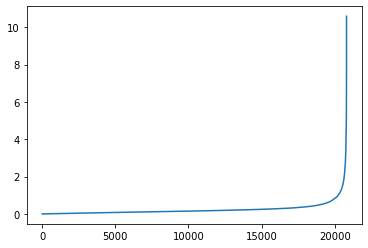

In [27]:
ae_sorted = np.sort(ae)
plt.plot(ae_sorted)

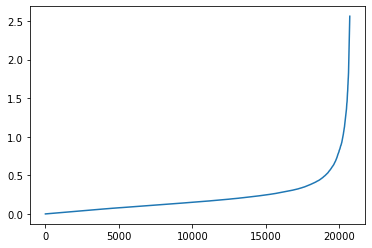

In [28]:
plt.plot(ae_sorted[:-100])

In [29]:
ae_sorted.mean()

0.23936316789311282

In [30]:
ae_sorted[:-100].mean()

0.22205072570625545